# Reference: Alexander Amini and Ava Soleimany, MIT 6.S191: Introduction to Deep Learning, [http://IntroToDeepLearning.com](http://introtodeeplearning.com/)

Source: https://github.com/aamini/introtodeeplearning/blob/lab3/lab3/solutions/RL_Solution.ipynb

In [1]:
# training with pid
# testing- with+without pid

In [2]:
#printing staff with pid

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time
import IPython, functools
from tqdm import tqdm
import tensorflow_probability as tfp
import math
from typing import Optional
from gym import spaces, logger
from gym.utils import seeding

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [5]:
!pip install dill #(or) conda install dill

import dill;

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.6 MB/s eta 0:00:00


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Download and import the MIT 6.S191 package
!printf "Installing MIT deep learning package... "
!pip install --upgrade git+https://github.com/aamini/introtodeeplearning.git &> /dev/null
!echo "Done"

Installing MIT deep learning package... Done


In [7]:
class CartPoleEnvCustomized_with_pid(gym.Env):
    """
    ### Description
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson in ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a
    frictionless track. The pendulum starts upright, and the goal is to prevent
    it from falling over by increasing and reducing the cart's velocity.
    ### Action Space
    The agent take a 1-element vector for actions.
    The action space is `(action)` in `[0, 1]`, where `action` is used to push
    the cart with a fixed amount of force:
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
    Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing.
    This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
    ### Observation Space
    The observation is a `ndarray` with shape `(4,)` where the elements correspond to the following:
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8*                 | 4.8*                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    **Note:** above denotes the ranges of possible observations for each element, but in two cases this range exceeds the
    range of possible values in an un-terminated episode:
    - `*`: the cart x-position can be observed between `(-4.8, 4.8)`, but an episode terminates if the cart leaves the
    `(-2.4, 2.4)` range.
    - `**`: Similarly, the pole angle can be observed between  `(-.418, .418)` radians or precisely **±24°**, but an episode is
    terminated if the pole angle is outside the `(-.2095, .2095)` range or precisely **±12°**
    ### Rewards
    Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.
    ### Starting State
    All observations are assigned a uniform random value between (-0.05, 0.05)
    ### Episode Termination
    The episode terminates of one of the following occurs:
    1. Pole Angle is more than ±12°
    2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
    3. Episode length is greater than 500 (200 for v0)
    ### Arguments
    No additional arguments are currently supported.
    """

    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"


        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        #self.i_threshold = self.force_mag / self.torque_const_Kt

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

        ### Customization changes ######
        self.DCMotor_radius = 0.15 #0.2 #### chnge actualy diameter and arm len for rotation
        '''add ElectricalDCMotorEnv to the CartPole class
        and assign values to
        Resistor_R, inductor_L, torque_const_Kt and bemf_const_Ke'''
        #self.Resistor_R=1.0
        #self.inductor_L=0.1
        #self.torque_const_Kt=1.0
        #self.bemf_const_Ke=1.0
        self.DCMotorModel = ElectricalDCMotorEnv()
        self.DCMotorModel.tau = self.tau
        self.DCMotorModel.Resistor_R = 1.0
        self.DCMotorModel.inductor_L = 0.1
        self.DCMotorModel.torque_const_Kt = 1.0
        self.DCMotorModel.bemf_const_Ke = 1.0
        ####

        ### change add force history
        self.past_force_action=0.0
        self.present_force_action=0.0
        self.past_force_filter=0.0
        self.present_force_filter=0.0
        #


    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag #+/-10N
        torque_wanted = force*self.DCMotor_radius

        ### Customization changes #####
        ''' set current refrence value current_ref and
        caclulate actual applied force F based DC motor model and PID control at
        DCMotorModel.step function
        '''
        #current_ref = force/self.DCMotorModel.torque_const_Kt
        current_ref = torque_wanted/self.DCMotorModel.torque_const_Kt
        #F = self.DCMotorModel.step(current_ref = current_ref,x_dot = x_dot)
        torque_actual = self.DCMotorModel.step(current_ref = current_ref,
                                   x_dot = x_dot/self.DCMotor_radius)
        F = torque_actual/self.DCMotor_radius
        #F = force #ideal env
        ###

        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            F + self.polemass_length * theta_dot ** 2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done: # if we inside the valid range
            reward = 1.0
            #reward = ((-4.3) * abs(theta) + 1)*((-0.375) * abs(x) + 1) * 100
            #l = (x**2) + 2 * x * self.length * sintheta + 2 * self.length**2 + (2 * self.length**2) * costheta
            #l = ((x-1)**2) + 2 * (x-1) * self.length * sintheta + 2 * self.length**2 + (2 * self.length**2) * costheta
            #reward = math.exp((-0.5 * l)/4.8)
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
            #reward = ((-4.3) * abs(theta) + 1)*((-0.375) * abs(x) + 1) * 100
            #l = (x**2) + 2 * x * self.length * sintheta + 2 * self.length**2 + (2 * self.length**2) * costheta
            #l = ((x-1)**2) + 2 * (x-1) * self.length * sintheta + 2 * self.length**2 + (2 * self.length**2) * costheta
            #reward = math.exp((-0.5 * l)/4.8)
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        #return np.array(self.state, dtype=np.float32), reward, done, {} ,force, F ###########################################################change_1#######
        return np.array(self.state, dtype=np.float32), reward, done, {} ,torque_wanted, torque_actual ###########################################################change_1#######


    def reset(self, return_info = False, options = None):
        #super().reset(seed=seed)
        #self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        self.DCMotorModel.current = 0.0
        self.DCMotorModel.current_error = 0.0
        self.DCMotorModel.current_error_acc = 0.0
        self.DCMotorModel.current_error_prev = 0.0
        #self.state = np.random.uniform(low=-0.05, high=0.05, size=(5,))
        self.steps_beyond_done = None

        ### change add force history
        self.past_force_action=0.0
        self.present_force_action=0.0
        self.past_force_filter=0.0
        self.present_force_filter=0.0
        #

        if not return_info:
            return np.array(self.state, dtype=np.float32)
        else:
            return np.array(self.state, dtype=np.float32), {}

    def render(self, mode="human"):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width / world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            #from gym.utils import pyglet_rendering
            from gym.envs.classic_control import rendering as pyglet_rendering

            self.viewer = pyglet_rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = pyglet_rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = pyglet_rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = (
                -polewidth / 2,
                polewidth / 2,
                polelen - polewidth / 2,
                -polewidth / 2,
            )
            pole = pyglet_rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(0.8, 0.6, 0.4)
            self.poletrans = pyglet_rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = pyglet_rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(0.5, 0.5, 0.8)
            self.viewer.add_geom(self.axle)
            self.track = pyglet_rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [8]:
class ElectricalDCMotorEnv():

      def __init__(self):
        self.Resistor_R = 1.0
        self.inductor_L = 0.1
        self.torque_const_Kt = 1.0
        self.bemf_const_Ke = 1.0
        self.tau = 0.02
        #
        #self.Kp = 1.0
        #self.Ki = 1.0
        #self.Kd = 1.0
        #self.aL=10**(-3)+(7./3 - 4./3 -1)#Low pass parameter
        #self.aH = 10**2 #High pass parameter

        self.Kp = 4.3 #5.0 #50.0
        self.Ki = 1.0 #10.0 #3.0
        self.Kd = 10.0**(-6)
        self.aL=10.0**(-3) #Low pass parameter
        self.aH = 10.0**2 #High pass parameter

        #self.Kp = 1.0
        #self.Ki = 10.0
        #self.Kd = 10**(-6)
        #self.aL=10.0**(-3) #Low pass parameter
        #self.aH = 10.0**2 #High pass parameter

        #
        self.current = 0.0
        self.current_error = 0.0
        self.current_error_acc = 0.0
        self.current_error_prev = 0.0
        self.voltage_input = 0.0
        self.xdot = 0.0
        self.PID_Discretization = "Simple" #"Backward", " "Bilinear" , "Forward" "Simple"
        #self.PID_Discretization = "Backward" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"
        #self.PID_Discretization = "Bilinear" #"Backward""Simple", " "Bilinear" , "Forward" "Simple"

      def step(self, current_ref, x_dot):
        aL = self.aL
        aH = self.aH
        self.current_error = current_ref-self.current
        delta_error = self.current_error-self.current_error_prev

        if self.PID_Discretization == "Simple":
          self.current_error_acc += self.current_error*self.tau
          HP_delta_error = delta_error

        elif self.PID_Discretization == "Backward":
          self.current_error_acc = (self.current_error_acc+(self.current_error)*self.tau)/(1+aL*self.tau) #Low Pass
          HP_delta_error = (self.current_error + aH*delta_error)/(1+aL*self.tau)#High Pass

        elif self.PID_Discretization == "Bilinear":
          error_avg = (self.current_error+self.current_error_prev)/2
          self.current_error_acc =  ((1-aL*self.tau/2)*self.current_error_acc + error_avg*self.tau)/(1+aL*self.tau/2)#Low Pass
          HP_delta_error =  ((1-aL*self.tau/2)*self.current_error + aH*delta_error)/(1+aL*self.tau/2)#High Pass

        else:
          self.current_error_acc = (1-aL*self.tau)*self.current_error_acc+(self.current_error_prev)*self.tau #Low Pass
          HP_delta_error = (1-aH*self.tau)*self.current_error + aH*delta_error #High Pass

        P = self.Kp*self.current_error
        #I = self.Ki*self.current_error_acc*self.tau
        I = self.Ki*self.current_error_acc
        #D = self.Kd*HP_delta_error/self.tau
        D = self.Kd*HP_delta_error/self.tau
        voltage_BEMF = x_dot*self.bemf_const_Ke
        voltage_input = P+I+D+voltage_BEMF + 0.6*current_ref
        voltage_input = np.clip(voltage_input, -20, 20)

        self.current_error_prev = 0+self.current_error
        self.current += self.tau*(voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
        self.voltage_input = voltage_input
        self.xdot = x_dot
        F=self.torque_const_Kt*self.current

        return F # return applied Force

In [9]:
### Instantiate a costimized Cartpole environment ###

env_with_pid = CartPoleEnvCustomized_with_pid()

In [10]:
n_observations = env_with_pid.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [11]:
n_observations_shape = env_with_pid.observation_space.shape
print("Environment has observation space Shape =", n_observations_shape)

Environment has observation space Shape = (4,)


In [12]:
n_actions = env_with_pid.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


In [13]:
### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        # INput Layer Added $$$$$$$$
        tf.keras.layers.Input(shape=n_observations_shape),
        # First Dense layer
        tf.keras.layers.Dense(units=32, activation='relu'),
        # Last Dense layer,
        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model

cartpole_model = create_cartpole_model()

In [14]:
### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model,
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observwhich is/are fed as input to the model
#   single: flag as to whether we are handling a single observation or batch of
#     observations, provided as an np.array
# Returns:
#   action: choice of agent action
def choose_action(model, observation, single=True):
    # add batch dimension to the observation if only a single example was provided
    observation = np.expand_dims(observation, axis=0) if single else observation

    # feed the observations through the model to predict the log probabilities of each possible action.
    logits = model.predict(observation)

    #Choose an action from the categorical distribution defined by the log
     #  probabilities of each possible action.
    action = tf.random.categorical(logits, num_samples=1)

    action = action.numpy().flatten()

    return action[0] if single else action

In [15]:
### Agent Memory ###

class Memory:
    def __init__(self):
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward):
        self.observations.append(new_observation)
        # update the list of actions with new action
        self.actions.append(new_action)
        # update the list of rewards with new reward
        self.rewards.append(new_reward)

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

In [16]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): #####################################################################################i_try_1
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)###########################################################################################i_try_2
    #return discounted_rewards


In [17]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards):
    '''Compute the negative log probabilities'''
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=actions)

    '''Scale the negative log probability by the rewards'''
    loss = tf.reduce_mean( neg_logprob * rewards )
    return loss

In [18]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else:
            prediction = model(observations)

        # call the compute_loss function to compute the loss
        loss = loss_function(prediction, actions, discounted_rewards)

    #run backpropagation to minimize the loss using the tape.gradient method.
    grads = tape.gradient(loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 2)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import numpy as np

from IPython import display as ipythondisplay
from string import Formatter





def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)
    #plt.grid(True)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)
    #plt.grid(True)

    plt.show()




class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla() # Clear the current axes.

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [20]:
# This class stores a filtered loss' history
# with a parameter smoothing_factor
class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

In [21]:
## Training parameters ##
## Re-run this cell to restart training from scratch ##

# Learning rate and optimizer
learning_rate = 1e-2 #1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = LossHistory(smoothing_factor=0.95)######################################################################i_try_3
#smoothed_reward = LossHistory(smoothing_factor=0.0)
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

Train with PID

In [22]:
t_max=200
t_between_action_choice=1 #2
total_reward_max = 500

In [23]:


env_with_pid = CartPoleEnvCustomized_with_pid()
env_with_pid.DCMotorModel.PID_Discretization = "Simple" # "Forward" or "Backward" or"
                                               #"Bilinear" or "Simple"
#cartpole_model = create_cartpole_model()

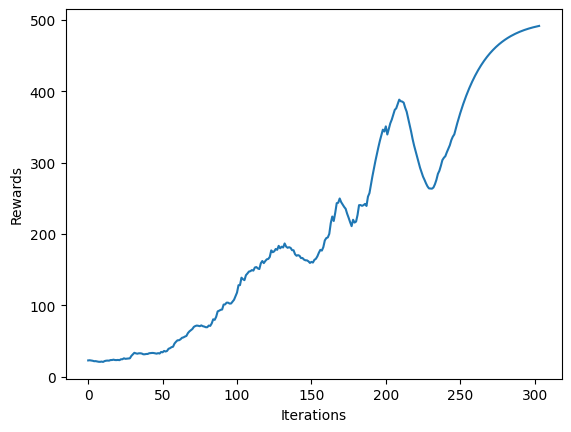

1/1 [==============================] - 0s 25ms/step


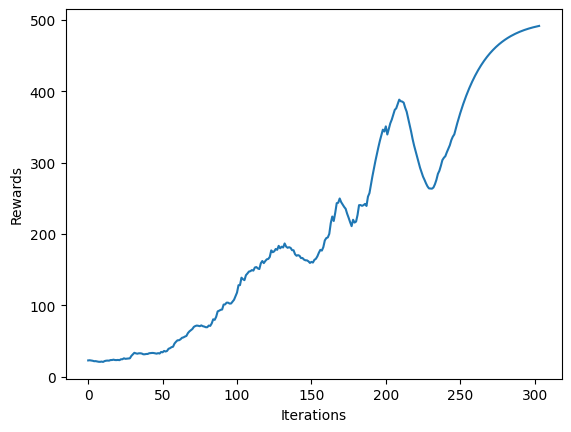

In [ ]:
## Cartpole training! ##
## Note: stoping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as
#        well (to re-initialize the model and optimizer)


#### new list for observation saving
save_observation = []
#force1, F1
save_force1 = []
save_F1 = []

num_episodes = 300 #200 # 1000
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(num_episodes):

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    observation = env_with_pid.reset()
    memory.clear()
    t=0
    #for n in range(501)
    while True:
        # using our observation, choose an action and take it in the environment
        if t%t_between_action_choice==0:
          action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info, force1, F1 = env_with_pid.step(action)#################################################change_2########################

        if i_episode == num_episodes - 1 :
          save_observation.append(next_observation)
          save_force1.append(force1)
          save_F1.append(F1)

        if t_max<t:
          t_max=t
          cartpole_model.save_weights('abc_best')
        t+=1

        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        total_reward = sum(memory.rewards)
        if done or total_reward>=total_reward_max:
            # determine total reward and keep a record of this
            #total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)

            # initiate training - remember we don't know anything about how the
            #   agent is doing until it has crashed!
            g = train_step(cartpole_model, compute_loss, optimizer,
                       observations=np.vstack(memory.observations),
                       actions=np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards))

            #if i_episode==0:
            #  cartpole_model.save_weights('abc_best')

            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation


cartpole_model.save('/content/drive/MyDrive/Saved_Data/Cartpole_DQN/model_last.keras')
cartpole_model.save_weights('/content/drive/MyDrive/Saved_Data/Cartpole_DQN/abc_last')
smoothed_reward_loss = np.array(smoothed_reward.loss)


In [ ]:
#############################################################################################################start the trained model??###############

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cartpole_model.save('/content/drive/MyDrive/Saved_Data/Cartpole_DQN/model_last.keras')

In [ ]:
# Save the entire session by creating a new pickle file
#dill.dump_session('./your_bk_dill.pkl')
dill.dump_session('/content/drive/MyDrive/Saved_Data/Cartpole_DQN/your_bk_dill.pkl');

In [ ]:
cartpole_model.save_weights('/content/drive/MyDrive/Saved_Data/Cartpole_DQN/abc_last')

In [ ]:
# Restore the entire session
dill.load_session('/content/drive/MyDrive/Saved_Data/Cartpole_DQN/your_bk_dill.pkl');

In [ ]:
smoothed_reward_loss = np.array(smoothed_reward.loss)

In [24]:
font = {'size': 15}
plt.rc('font', **font)


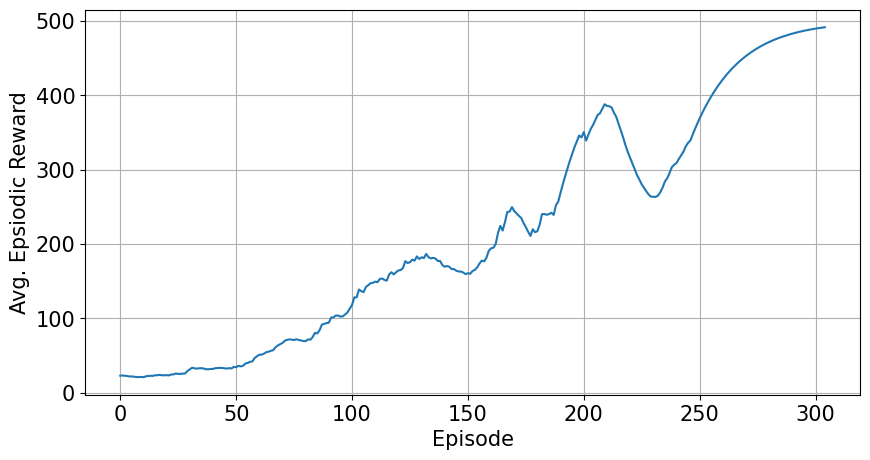

In [ ]:
# Plotting graph
# Episodes versus Avg. Rewards
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(smoothed_reward.loss)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.grid()
plt.show()

In [ ]:
#test with pid part

In [25]:
model_1 = create_cartpole_model()
model_1.build((32,4))
#model_1.load_weights('abc_best')
model_1.load_weights('/content/drive/MyDrive/Saved_Data/Cartpole_DQN/abc_last')


In [26]:
### Test
memory.clear()
observation = env_with_pid.reset()
save_observation = []
#force1, F1
save_force1 = []
save_F1 = []

done=False
t=0
while not done and t<702:
    # using our observation, choose an action and take it in the environment
    if t%t_between_action_choice==0:
      action = choose_action(model_1, observation)
    next_observation, reward, done, info, force1, F1 = env_with_pid.step(action)#################################################change_2########################
    save_observation.append(next_observation)
    save_force1.append(force1)
    save_F1.append(F1)
    observation = next_observation
    t+=1



1/1 [==============================] - 0s 29ms/step


In [27]:
'''
## Training parameters ##
## Re-run this cell to restart training from scratch ##

# Learning rate and optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = LossHistory(smoothing_factor=0.95)######################################################################i_try_3
#smoothed_reward = LossHistory(smoothing_factor=0.0)
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')
'''

"\n## Training parameters ##\n## Re-run this cell to restart training from scratch ##\n\n# Learning rate and optimizer\nlearning_rate = 1e-3\noptimizer = tf.keras.optimizers.Adam(learning_rate)\n\n# instantiate cartpole agent\ncartpole_model = create_cartpole_model()\n\n# to track our progress\nsmoothed_reward = LossHistory(smoothing_factor=0.95)######################################################################i_try_3\n#smoothed_reward = LossHistory(smoothing_factor=0.0)\nplotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')\n"

In [28]:
'''
###Test
#### new list for observation saving

best_model = create_cartpole_model()
best_model.build((32,4))
best_model.load_weights('abc')

save_observation = []
#force1, F1
save_force1 = []
save_F1 = []

#best_reward=-100

env_with_pid = CartPoleEnvCustomized_with_pid()
env_with_pid.DCMotorModel.PID_Discretization = "Simple" # "Forward" or "Backward" or"
                                               #"Bilinear" or "Simple

observation = env_with_pid.reset()
t=0
done = False
while not done:
  if t%5==0:
    action = choose_action(best_model, observation)
  next_observation, reward, done, info, force1, F1 = env_with_pid.step(action)
  save_observation.append(next_observation)
  save_force1.append(force1)
  save_F1.append(F1)
  t+=1
#end while
'''


'\n###Test\n#### new list for observation saving\n\nbest_model = create_cartpole_model()\nbest_model.build((32,4))\nbest_model.load_weights(\'abc\')\n\nsave_observation = []\n#force1, F1\nsave_force1 = []\nsave_F1 = []\n\n#best_reward=-100\n\nenv_with_pid = CartPoleEnvCustomized_with_pid()\nenv_with_pid.DCMotorModel.PID_Discretization = "Simple" # "Forward" or "Backward" or"\n                                               #"Bilinear" or "Simple\n\nobservation = env_with_pid.reset()\nt=0\ndone = False\nwhile not done:\n  if t%5==0:\n    action = choose_action(best_model, observation)\n  next_observation, reward, done, info, force1, F1 = env_with_pid.step(action)\n  save_observation.append(next_observation)\n  save_force1.append(force1)\n  save_F1.append(F1)\n  t+=1\n#end while\n'

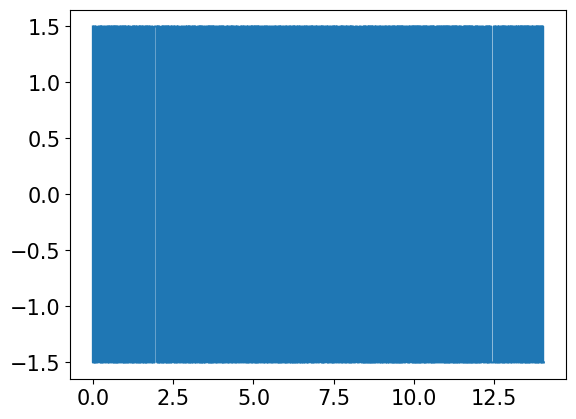

In [29]:
# Plotting the Graph
# range(start, stop, step) # tau =0.02
time_position_force1= np.linspace(start = 0, stop = len(save_force1)* 0.02,num=len(save_force1) )
#plt.plot(time_position_force1, save_force1)
'''
plt.title("position time responce")
plt.xlabel("time")
plt.ylabel("position")
'''
plt.step(time_position_force1, save_force1)
plt.show()

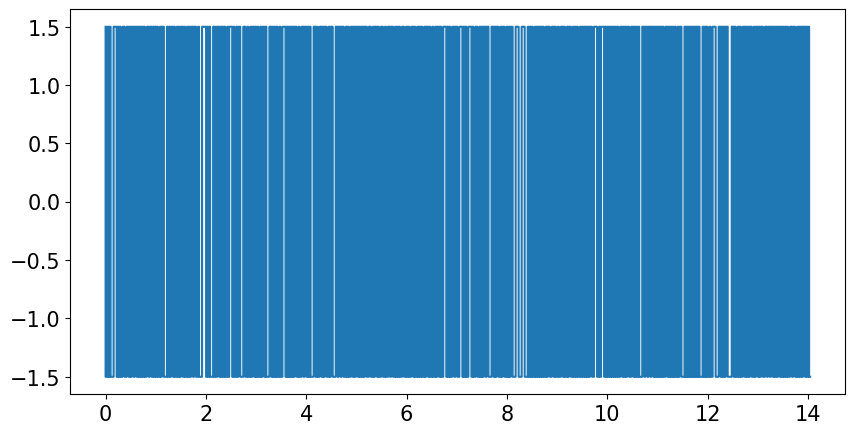

In [30]:
# Plotting the Graph
# range(start, stop, step) # tau =0.02
time_position_force1= np.linspace(start = 0, stop = len(save_force1)* 0.02,num=len(save_force1) )
#plt.plot(time_position_force1, save_force1)
'''
plt.title("position time responce")
plt.xlabel("time")
plt.ylabel("position")
'''

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.step(time_position_force1, save_force1)
plt.show()


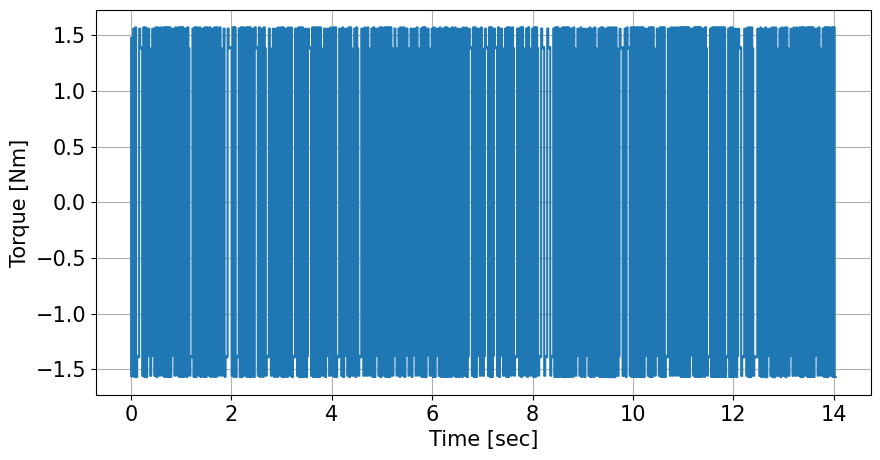

In [31]:
# Plotting the Graph

#time_position_save_F1, save_F1
# range(start, stop, step) # tau =0.02
time_position_save_F1= np.linspace(start = 0, stop = len(save_F1)* 0.02,num=len(save_F1) )
#plt.plot(time_position_force1, save_force1)
'''
plt.title("position time responce")
plt.xlabel("time")
plt.ylabel("position")
'''

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.step(time_position_save_F1, save_F1)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Torque [Nm]')
plt.show()

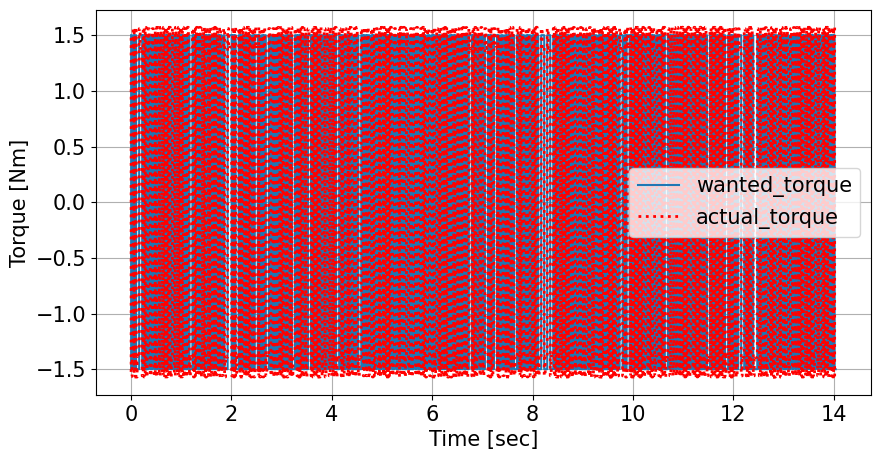

In [32]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

#sign_error = np.sign(np.array(save_force1)) - np.sign(np.array(save_F1))
plt.step(time_position_force1, save_force1,label = "wanted_torque")
plt.step(time_position_save_F1, save_F1,':',label = "actual_torque",color="red",linewidth = 2)
#plt.step(time_position_save_F1, sign_error,'--',label = "sign_error",color="black",linewidth = 1)
plt.legend()
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Torque [Nm]')
plt.show()

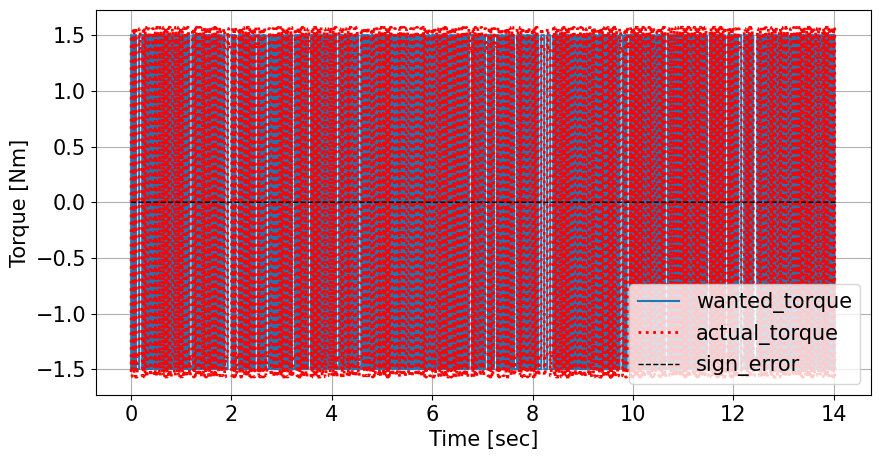

In [33]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

sign_error = np.sign(np.array(save_force1)) - np.sign(np.array(save_F1))
plt.step(time_position_force1, save_force1,label = "wanted_torque")
plt.step(time_position_save_F1, save_F1,':',label = "actual_torque",color="red",linewidth = 2)
plt.step(time_position_save_F1, sign_error,'--',label = "sign_error",color="black",linewidth = 1)
plt.legend()
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Torque [Nm]')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


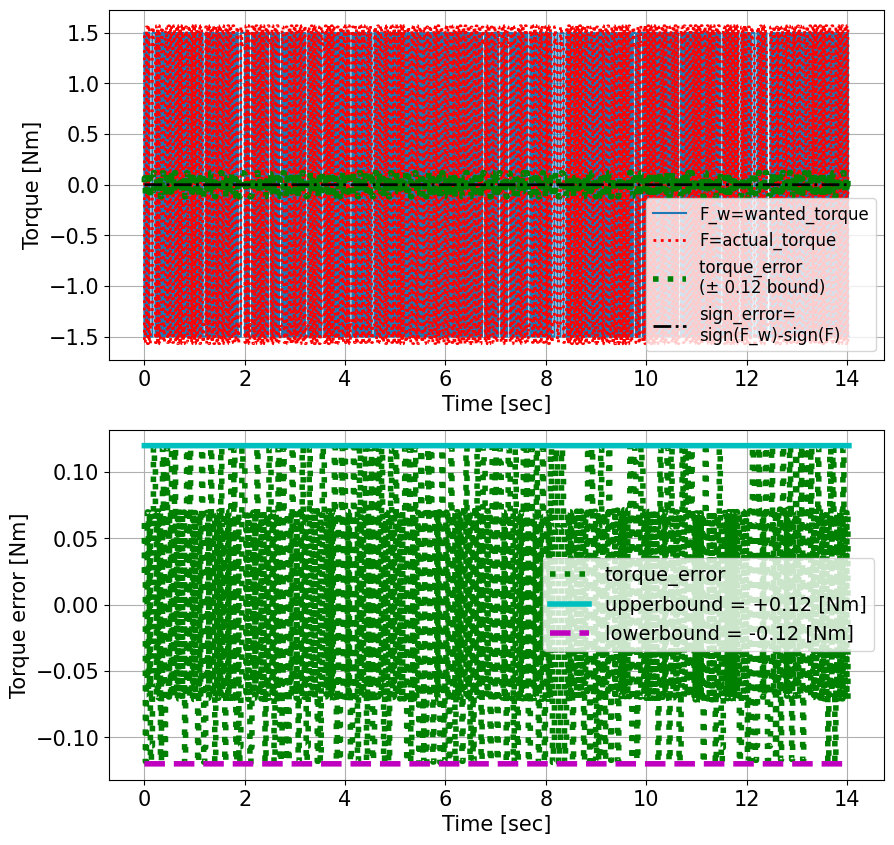

In [65]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

sign_error = np.sign(np.array(save_force1)) - np.sign(np.array(save_F1))
force_error = np.array(save_force1) - np.array(save_F1) ### add
force_error_max = np.max(np.abs(force_error))

plt.subplot(2, 1, 1)
plt.step(time_position_force1, save_force1,label = "F_w=wanted_torque")
plt.step(time_position_save_F1, save_F1,':',label = "F=actual_torque",color="red",linewidth = 2)
plt.step(time_position_save_F1, force_error,':',
         label = f"torque_error \n(± {force_error_max:.2f} bound)",
         color="green",linewidth = 4) ### add
plt.step(time_position_save_F1, sign_error,'-.',label = "sign_error=\nsign(F_w)-sign(F)",color="black",linewidth = 2)
plt.legend(fontsize = 12)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Torque [Nm]')

plt.subplot(2, 1, 2)
plt.step(time_position_save_F1, force_error,':',
         label = "torque_error",
         color="green",linewidth = 4) ### add
plt.step(time_position_save_F1, force_error*0+force_error_max,'-',
         label = f"upperbound = +{force_error_max:.2f} [Nm]",
         color="c",linewidth = 4) ### add
plt.step(time_position_save_F1, force_error*0-force_error_max,'--',
         label = f"lowerbound = -{force_error_max:.2f} [Nm]",
         color="m",linewidth = 4) ### add
plt.xlabel('Time [sec]')
plt.ylabel('Torque error [Nm]')
plt.legend(fontsize = 14)
plt.grid()

plt.show()

In [35]:
print(f"error (± {np.max(np.abs(force_error)):.2f} bound)")

error (± 0.12 bound)


In [36]:
# distribution to 4 observation parameters

position = []
velocity = []
angle = []
angular_velocity = []
for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      position.append(value)
    if index == 1:
      velocity.append(value)
    if index == 2:
      angle.append(value)
    if index == 3:
      angular_velocity.append(value)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


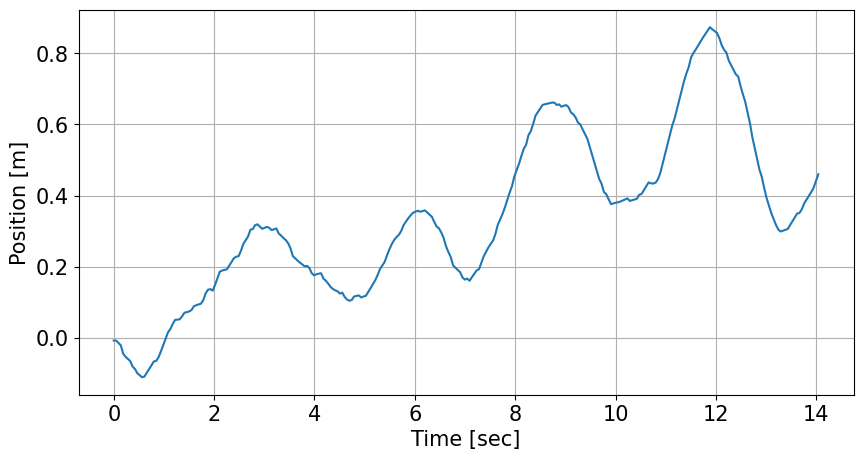

In [50]:
from scipy.interpolate import make_interp_spline, BSpline

time_position = np.linspace(start = 0, stop = len(position)* 0.02,num=len(position))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_position[-1] , 300)

spl = make_interp_spline(time_position, position, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')
plt.show()

In [38]:
print(len(position))


702


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


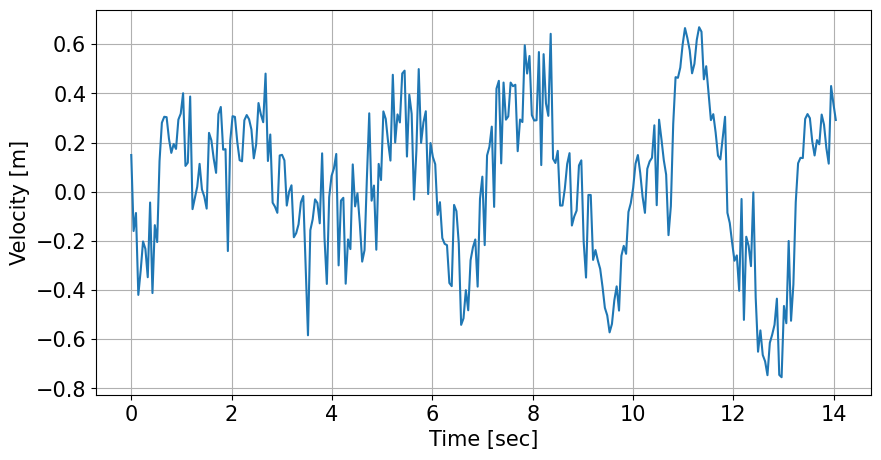

In [51]:
from scipy.interpolate import make_interp_spline, BSpline

time_velocity = np.linspace(start = 0, stop = len(velocity)* 0.02,num=len(velocity))
#time_velocity , velocity
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_velocity[-1] , 300)

spl = make_interp_spline(time_velocity, velocity, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Velocity [m]')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


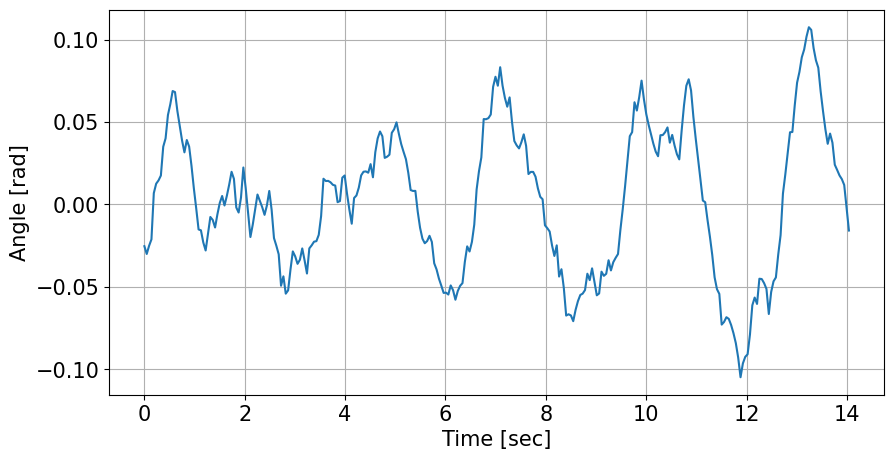

In [52]:
from scipy.interpolate import make_interp_spline, BSpline

time_angle = np.linspace(start = 0, stop = len(angle)* 0.02,num=len(angle))
#time_angle , angle
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_angle[-1] , 300)

spl = make_interp_spline(time_angle,angle, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Angle [rad]')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


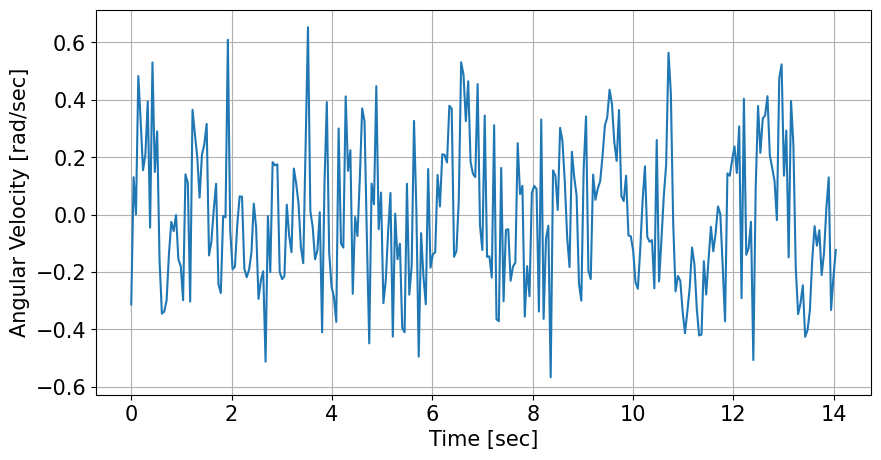

In [53]:
from scipy.interpolate import make_interp_spline, BSpline

time_angular_velocity = np.linspace(start = 0, stop = len(angular_velocity)* 0.02,num=len(angular_velocity))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_angular_velocity[-1] , 300)

spl = make_interp_spline(time_angular_velocity, angular_velocity, k=3)  # type: BSpline
power_smooth = spl(xnew)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(xnew, power_smooth)
plt.grid()
plt.xlabel('Time [sec]')
plt.ylabel('Angular Velocity [rad/sec]')
plt.show()